In [10]:
import time
import os
import sys
import pandas as pd
from pathlib import Path

sys.path.append(os.path.join(Path().resolve(), "utils"))

from TestUser import TestUser
from get_resource_status import get_resource_status


challenge_id = 1

min_concurrent_instances = 5
max_concurrent_instances = 50
step_concurrent_instances = 5

duration_seconds_per_test = 10
resource_status_polling_interval_seconds = 1

timeout_until_measurement_seconds = 10


df = pd.DataFrame(columns=[
    'concurrent_instances',
    'try_number',
    'average_cpu_percent',
    'max_cpu_percent',
    'min_cpu_percent',
    'average_memory_percent',
    'max_memory_percent',
    'min_memory_percent'
])

users = []

for amount in range(min_concurrent_instances, max_concurrent_instances + 1, step_concurrent_instances):
    print(f'Starting test with {amount} concurrent instances...')


    print('Creating users...')

    new_users = []
    for i in range(len(users), amount):
        user = TestUser(
            username=f'testuser_{i+1}',
            password='testpass',
            email=f'test{i+1}@test.com'
        )
        new_users.append(user)

    for user in new_users:
        user.create()

    print('Launching challenges...')

    for user in new_users:
        user.launch_challenge(challenge_id)

    users.extend(new_users)

    print('Waiting for all challenges to be running...')
    time.sleep(timeout_until_measurement_seconds)

    start_time = time.time()

    print('Collecting resource status data...')
    cpu_percents = []
    memory_percents = []
    while True:
        try:
            status = get_resource_status()

            if status is None:
                print('Failed to get resource status, retrying...')
                time.sleep(resource_status_polling_interval_seconds)
                continue

        except Exception as e:
            pass

        cpu_percents.append(status['cpu'] * 100)
        memory_percent = status['memory']['used'] / status['memory']['total'] * 100
        memory_percents.append(memory_percent)

        while time.time() - start_time < resource_status_polling_interval_seconds:
            pass

        if time.time() - start_time >= duration_seconds_per_test:
            break

    print('Finished collecting resource status data.')

    average_cpu_percent = sum(cpu_percents) / len(cpu_percents)
    max_cpu_percent = max(cpu_percents)
    min_cpu_percent = min(cpu_percents)

    average_memory_percent = sum(memory_percents) / len(memory_percents)
    max_memory_percent = max(memory_percents)
    min_memory_percent = min(memory_percents)

    df = pd.concat([df, pd.DataFrame([{
        'concurrent_instances': amount,
        'try_number': try_number,
        'average_cpu_percent': average_cpu_percent,
        'max_cpu_percent': max_cpu_percent,
        'min_cpu_percent': min_cpu_percent,
        'average_memory_percent': average_memory_percent,
        'max_memory_percent': max_memory_percent,
        'min_memory_percent': min_memory_percent
    }])], ignore_index=True)

    print(f'Test with {amount} concurrent instances, try {try_number} completed.')
    print(f'Average CPU Percent: {average_cpu_percent:.2f}%')
    print(f'Max CPU Percent: {max_cpu_percent:.2f}%')
    print(f'Min CPU Percent: {min_cpu_percent:.2f}%')
    print(f'Average Memory Percent: {average_memory_percent:.2f}%')
    print(f'Max Memory Percent: {max_memory_percent:.2f}%')
    print(f'Min Memory Percent: {min_memory_percent:.2f}%')
    print()

print('Starting cleanup...')
print('Stopping challenges...')
for user in users:
    user.stop_challenge(challenge_id)
    time.sleep(1)

print('Deleting users...')

for user in users:
    user.delete()
    time.sleep(1)
print('Cleanup completed.')

Starting test with 5 concurrent instances...
Creating users...
Launching challenges...
Waiting for all challenges to be running...
Finished collecting resource status data.
Test with 5 concurrent instances, try 1 completed.
Average CPU Percent: 28.93%
Max CPU Percent: 35.12%
Min CPU Percent: 0.00%
Average Memory Percent: 3.13%
Max Memory Percent: 3.22%
Min Memory Percent: 2.99%

Starting test with 10 concurrent instances...
Creating users...


/tmp/ipykernel_42105/1423924816.py:103: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{


Launching challenges...
Waiting for all challenges to be running...
Finished collecting resource status data.
Test with 10 concurrent instances, try 1 completed.
Average CPU Percent: 24.94%
Max CPU Percent: 32.71%
Min CPU Percent: 14.71%
Average Memory Percent: 5.72%
Max Memory Percent: 5.89%
Min Memory Percent: 5.52%

Starting test with 15 concurrent instances...
Creating users...
Launching challenges...
Waiting for all challenges to be running...
Finished collecting resource status data.
Test with 15 concurrent instances, try 1 completed.
Average CPU Percent: 28.51%
Max CPU Percent: 36.43%
Min CPU Percent: 20.25%
Average Memory Percent: 8.17%
Max Memory Percent: 8.30%
Min Memory Percent: 7.98%

Starting test with 20 concurrent instances...
Creating users...
Launching challenges...
Waiting for all challenges to be running...
Finished collecting resource status data.
Test with 20 concurrent instances, try 1 completed.
Average CPU Percent: 55.20%
Max CPU Percent: 68.02%
Min CPU Percent:

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

cpu_stats = df.melt(
    id_vars=['concurrent_instances', 'try_number'],
    value_vars=['average_cpu_percent', 'max_cpu_percent', 'min_cpu_percent'],
    var_name='Metric',
    value_name='CPU Percent'
)

cpu_stats.replace(
    {
        'average_cpu_percent': 'Average CPU Percent',
        'max_cpu_percent': 'Max CPU Percent',
        'min_cpu_percent': 'Min CPU Percent'
    },
    inplace=True
)


memory_stats = df.melt(
    id_vars=['concurrent_instances', 'try_number'],
    value_vars=['average_memory_percent', 'max_memory_percent', 'min_memory_percent'],
    var_name='Metric',
    value_name='Memory Percent'
)

memory_stats.replace(
    {
        'average_memory_percent': 'Average Memory Percent',
        'max_memory_percent': 'Max Memory Percent',
        'min_memory_percent': 'Min Memory Percent'
    },
    inplace=True
)


df.head()

ValueError: value_name (CPU Percent) cannot match an element in the DataFrame columns.

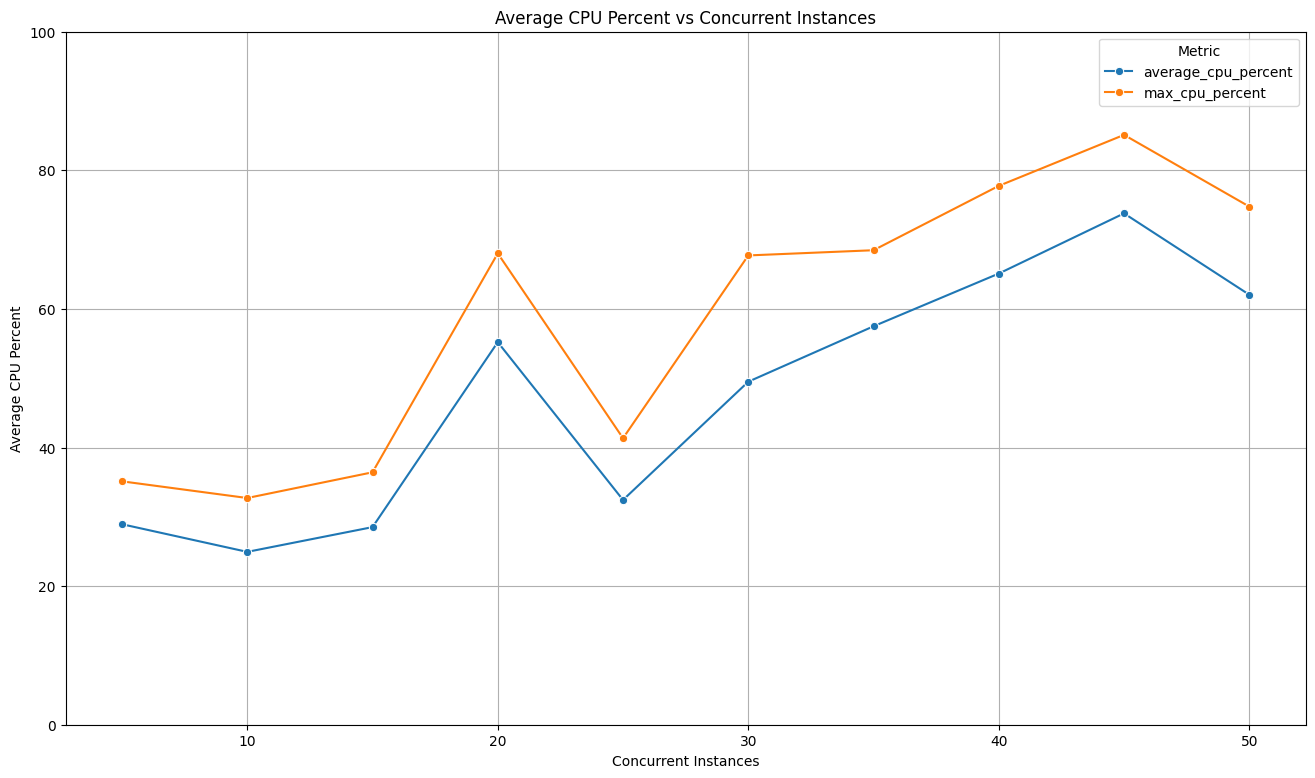

In [44]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=cpu_stats, x='concurrent_instances', y='CPU Percent', hue='Metric', marker='o')
plt.title('CPU Usage vs Concurrent Challenge Instances')
plt.xlabel('Number of Concurrent Challenge Instances')
plt.ylabel('CPU Usage (%)')
plt.ylim(0, 100)
plt.grid()
plt.show()


In [ ]:
plt.figure(figsize=(16, 9))

sns.lineplot(data=memory_stats, x='concurrent_instances', y='Memory Percent', hue='Metric', marker='o')
plt.title('Memory Usage vs Concurrent Challenge Instances')
plt.xlabel('Number of Concurrent Challenge Instances')
plt.ylabel('Memory Usage (%)')
plt.ylim(0, 100)
plt.grid()
plt.show()